In [1]:
import kan
import kan.utils as ku
import torch
import torch.nn as nn
import numpy as np
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions
import numpy.random as npr
import qutip as qt
import sympy
import random

In [260]:
N=8; J1=1; J2=0.65

In [261]:
h = j1j2_functions.J1J2_hamiltonian(N, J1, J2)
eigs = h.eigenstates()
gs = eigs[1][0]
gse = eigs[0][0]
print(gse)

-12.568669559253907


In [262]:
states, signs = utils.get_nonzero_states(N, gs, 1e-10)

In [263]:
len(states)

52

In [259]:
pred_signs =  [-1 + 2 * (magnetization.count_half_magnetization(i, odd=True) % 2) for i in states]
deviations = utils.find_sign_deviations(states, signs, pred_signs)
len(deviations)

32

In [114]:
for state in states:
    if magnetization.count_magnetization(state) != N/2:
        print('fail')

In [115]:
print(0b11110 in deviations)
print(0b1111 in deviations)

False
True


In [116]:
for state in deviations:
    print(bin(state))

0b1111
0b10111
0b101011
0b101101
0b110011
0b110101
0b111010
0b111100
0b1001011
0b1001101
0b1010011
0b1011100
0b1110001
0b10001110
0b10100011
0b10101100
0b10110010
0b10110100
0b11000011
0b11000101
0b11001010
0b11001100
0b11010010
0b11010100
0b11101000
0b11110000


In [264]:
nnz = []
num_violations = []
J2s = np.arange(0, 1 + 0.05, 0.05)
for J2 in J2s:
    h = j1j2_functions.J1J2_hamiltonian(N, J1, J2)
    eigs = h.eigenstates()
    gs = eigs[1][0]
    states, signs = utils.get_nonzero_states(N, gs, 1e-10)
    nnz.append(len(states))

    pred_signs =  np.array([-1 + 2 * (magnetization.count_half_magnetization(i, odd=True) % 2) for i in states])
    dev1 = utils.find_sign_deviations(states, signs, pred_signs)
    dev2 = utils.find_sign_deviations(states, signs, -1 * pred_signs)
    num_violations.append(min(len(dev1), len(dev2)))

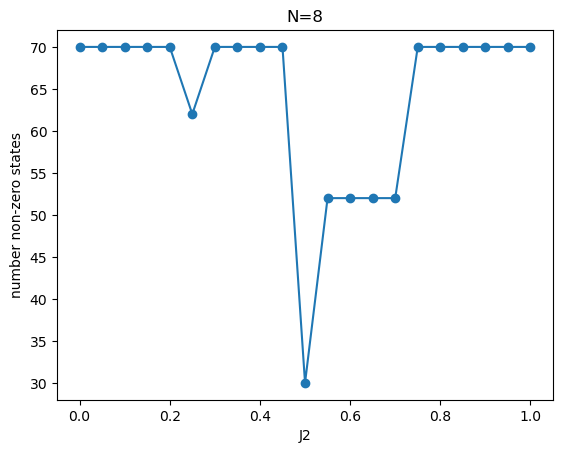

In [265]:
import matplotlib.pyplot as plt
plt.plot(J2s, nnz)
plt.scatter(J2s, nnz)
plt.xlabel('J2')
plt.ylabel('number non-zero states')
plt.title('N=8')
plt.show()

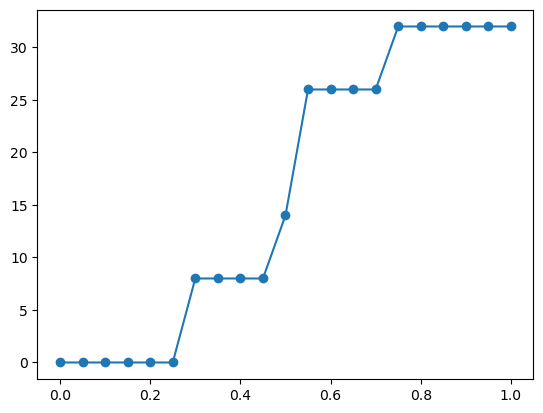

In [266]:
plt.plot(J2s, num_violations)
plt.scatter(J2s, num_violations)
plt.show()

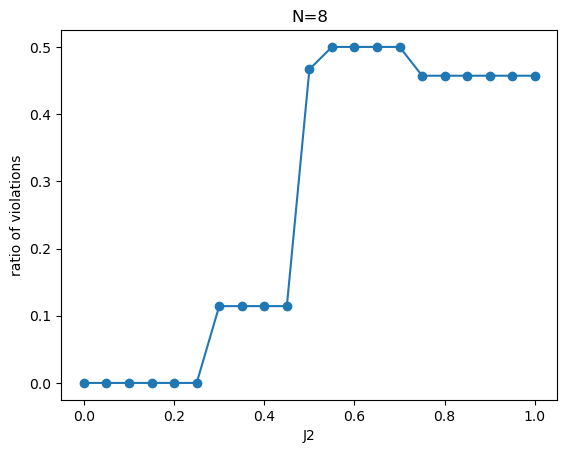

In [267]:
ratio_violation = np.array(num_violations) / np.array(nnz)
plt.plot(J2s, ratio_violation)
plt.scatter(J2s, ratio_violation)
plt.xlabel('J2')
plt.ylabel('ratio of violations')
plt.title('N=8')
plt.show()

In [121]:
J2s

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [271]:
N=10; J1=1; J2=0.6
h10 = j1j2_functions.J1J2_hamiltonian(N, J1, J2)
eigs10 = h10.eigenstates()
gs10 = eigs10[1][0]
gse10 = eigs10[0][0]
print(gse10)

-15.258763161434914


In [272]:
states, signs = utils.get_nonzero_states(N, gs10, 1e-10)

In [273]:
input = utils.generate_input_samples(N, states)
labels = torch.tensor(signs).reshape((-1, 1))
print(input.shape, labels.shape)

torch.Size([200, 10]) torch.Size([200, 1])


In [274]:
dataset = {'train_input': input, 'train_label': labels, 'test_input': input, 'test_label': labels}

In [275]:
kan_model = kan.KAN(width=[N, N, 1]) # seems [N, 5, 1] is smallest with lamb=0
kan_model(dataset['train_input']);""
# kan_model.fix_symbolic(2, 0, 0, 'tanh'); # seems no fixing might be better?

checkpoint directory created: ./model
saving model version 0.0


''

In [276]:
kan_model.fit(dataset, steps=50, lamb=1.5e-3); # max maybe 1.5e-3 reg

| train_loss: 8.38e-02 | test_loss: 8.38e-02 | reg: 3.62e+01 | : 100%|█| 50/50 [00:14<00:00,  3.45it

saving model version 0.1


In [277]:
print(torch.sqrt(torch.mean((labels - kan_model(input)) ** 2)))
print(torch.sqrt(torch.mean((labels - torch.sgn(kan_model(input))) ** 2)))

tensor(0.0838, grad_fn=<SqrtBackward0>)
tensor(0., grad_fn=<SqrtBackward0>)


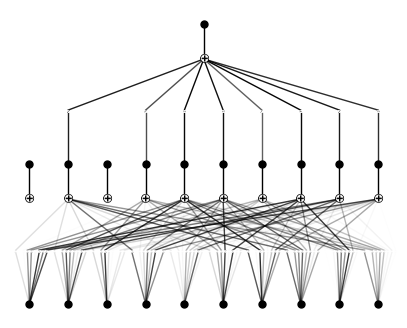

In [278]:
kan_model.plot()

node 0
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0      sin    0.691830 -1.698154           2                2   -0.588708
1      cos    0.691830 -1.698154           2                2   -0.588708
2        x    0.264128 -0.442455           1                1   -0.009718
3        0    0.000000  0.000014           0                0    0.000010
4    1/x^2    0.271653 -0.457283           2                2    0.279902
node 1
   function  fitting r2   r2 loss  complexity  complexity loss  total loss
0       cos    0.993627 -7.291620           2                2   -4.504134
1       sin    0.993627 -7.291566           2                2   -4.504096
2  gaussian    0.617141 -1.385076           3                3   -0.069553
3         0    0.000000  0.000014           0                0    0.000010
4         x    0.021992 -0.032067           1                1    0.277553
node 2
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0      sin 

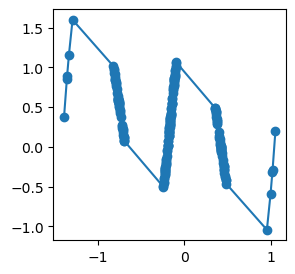

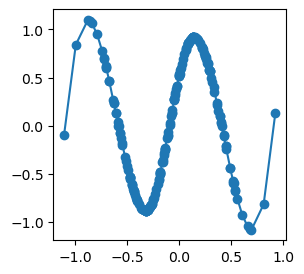

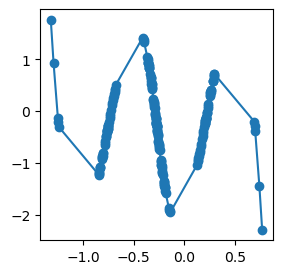

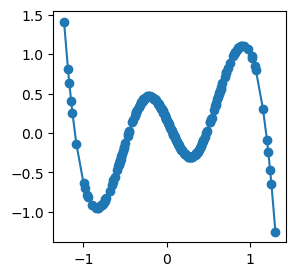

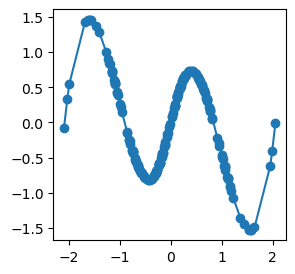

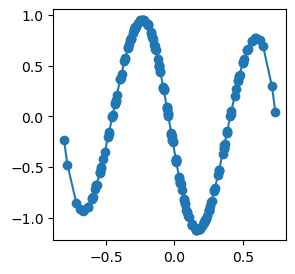

In [239]:
for i in range(6):
    print(f'node {i}')
    kan_model.get_fun(1, i, 0);
    kan_model.suggest_symbolic(1, i, 0, weight_simple=0.3);

In [240]:
kan_model.auto_symbolic(weight_simple=0.3, r2_threshold=0.95)
kan_model.fit(dataset, steps=20, lamb=1e-3);

fixing (0,0,0) with x, r2=1.0000011920928955, c=1
fixing (0,0,1) with x, r2=1.0000009536743164, c=1
fixing (0,0,2) with x, r2=1.0000008344650269, c=1
fixing (0,0,3) with x, r2=1.0000011920928955, c=1
fixing (0,0,4) with x, r2=1.0000005960464478, c=1
fixing (0,0,5) with x, r2=1.000001072883606, c=1
fixing (0,1,0) with x, r2=0.9999996423721313, c=1
fixing (0,1,1) with x, r2=1.0000008344650269, c=1
fixing (0,1,2) with x, r2=1.0000005960464478, c=1
fixing (0,1,3) with x, r2=1.000001072883606, c=1
fixing (0,1,4) with x, r2=1.000001072883606, c=1
fixing (0,1,5) with exp, r2=1.0000014305114746, c=2
fixing (0,2,0) with x, r2=1.0000007152557373, c=1
fixing (0,2,1) with x, r2=1.0000009536743164, c=1
fixing (0,2,2) with x, r2=1.0000004768371582, c=1
fixing (0,2,3) with x, r2=0.9999999403953552, c=1
fixing (0,2,4) with x, r2=1.0000005960464478, c=1
fixing (0,2,5) with x, r2=1.000000238418579, c=1
fixing (0,3,0) with x, r2=0.9999998807907104, c=1
fixing (0,3,1) with x, r2=1.0000008344650269, c=1
fi

| train_loss: 3.15e-01 | test_loss: 3.15e-01 | reg: 5.68e+00 | : 100%|█| 20/20 [00:03<00:00,  5.16it

saving model version 0.3


In [241]:
print(torch.sqrt(torch.mean((labels - kan_model(input)) ** 2)))
print(torch.sqrt(torch.mean((labels - torch.sgn(kan_model(input))) ** 2)))

tensor(0.3147, grad_fn=<SqrtBackward0>)
tensor(0., grad_fn=<SqrtBackward0>)


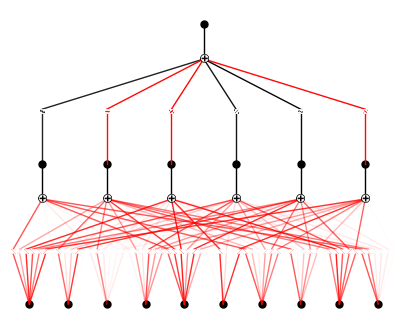

In [242]:
kan_model.plot()

node 0
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0      sin    0.691219 -1.695296           2                2   -0.586707
1      cos    0.691218 -1.695295           2                2   -0.586707
2        x    0.271915 -0.457800           1                1   -0.020460
3        0    0.000000  0.000014           0                0    0.000010
4    1/x^2    0.291461 -0.497061           2                2    0.252057
node 1
    function   fitting r2    r2 loss  complexity  complexity loss  total loss
0          0 -100000000.0  26.575425           0                0   18.602797
1          x -100000000.0  26.575425           1                1   18.902797
2      1/x^2 -100000000.0  26.575425           2                2   19.202797
3        x^2 -100000000.0  26.575425           2                2   19.202797
4  1/sqrt(x) -100000000.0  26.575425           2                2   19.202797
node 2
    function   fitting r2    r2 loss  complexity  complexity loss  

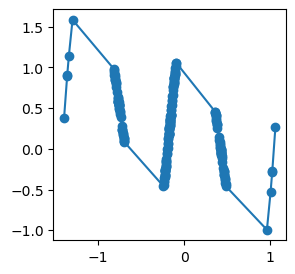

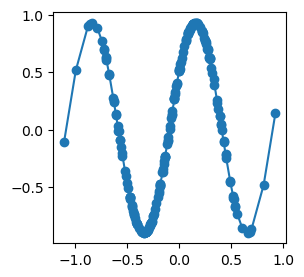

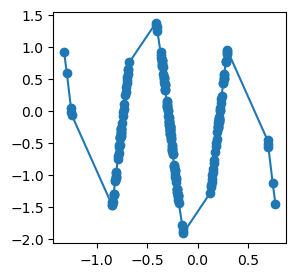

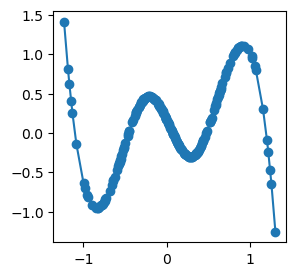

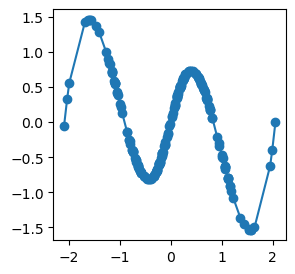

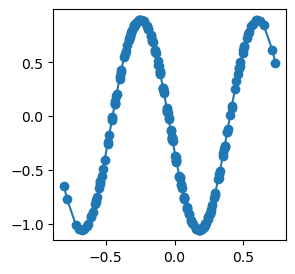

In [243]:
for i in range(6):
    print(f'node {i}')
    kan_model.get_fun(1, i, 0);
    kan_model.suggest_symbolic(1, i, 0, weight_simple=0.3);

In [205]:
for i in range(1, 5):
    kan_model.fix_symbolic(1, i, 0, 'cos');
kan_model.fit(dataset, steps=20);

r2 is 0.0991559848189354
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.4
r2 is 0.8558481335639954
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.5
r2 is 0.9717003703117371
saving model version 0.6
Best value at boundary.
r2 is 0.7497007250785828
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.7


| train_loss: 5.10e-01 | test_loss: 5.10e-01 | reg: 1.95e+01 | : 100%|█| 20/20 [00:07<00:00,  2.69it

saving model version 0.8


In [206]:
print(torch.sqrt(torch.mean((labels - kan_model(input)) ** 2)))
print(torch.sqrt(torch.mean((labels - torch.sgn(kan_model(input))) ** 2)))

tensor(0.5098, grad_fn=<SqrtBackward0>)
tensor(0.4243, grad_fn=<SqrtBackward0>)


In [ ]:
kan_model.fit(dataset, steps=20, lamb=1e-3);

| train_loss: 2.67e-02 | test_loss: 2.67e-02 | reg: 2.77e+01 | : 100%|█| 20/20 [00:06<00:00,  3.02it

saving model version 0.2


In [139]:
print(torch.sqrt(torch.mean((labels - kan_model(input)) ** 2)))
print(torch.sqrt(torch.mean((labels - torch.sgn(kan_model(input))) ** 2)))

tensor(0.0267, grad_fn=<SqrtBackward0>)
tensor(0., grad_fn=<SqrtBackward0>)


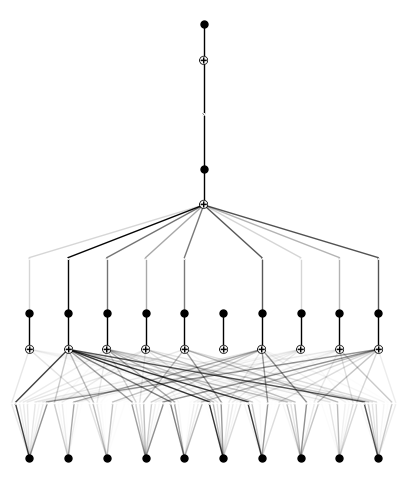

In [140]:
kan_model.plot()

In [141]:
kan_model.fit(dataset, steps=20, lamb=1e-2);

| train_loss: 1.02e-01 | test_loss: 1.02e-01 | reg: 2.02e+01 | : 100%|█| 20/20 [00:06<00:00,  3.20it

saving model version 0.3


In [142]:
print(torch.sqrt(torch.mean((labels - torch.sgn(kan_model(input))) ** 2)))

tensor(0., grad_fn=<SqrtBackward0>)


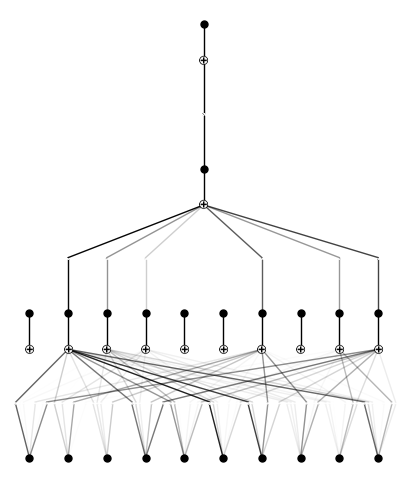

In [145]:
kan_model.plot()